# <span style="color:white">**Projet ML - Bike Sharing**</span>

## <span style="color:powderblue">**Imports and Setup**</span>

### <span style="color:lightcyan">**Imports**</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import Holt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
#import sklearn.svm as svm
#import sklearn.feature_selection as feature_select
#import sklearn.feature_extraction as feature_extract
#import sklearn.preprocessing as preprocessing
#import sklearn.neural_network as nn

### <span style="color:lightcyan">**Data preparation**</span>

In [2]:
day_df = pd.read_csv("./data/day.csv")
hour_df = pd.read_csv("./data/hour.csv")

In [3]:
# Fonction pour ajouter la feature "day" aux dataframe en l'extrayant de datetime 
def extract_day_of_month(df, date_column):
    df["day"] = pd.to_datetime(df[date_column],format="%Y-%m-%d").dt.day
    return df

In [4]:
# Utilisation de la fonction précédente sur les deux csv
day_df = extract_day_of_month(day_df, "dteday")
hour_df = extract_day_of_month(hour_df, "dteday")

# Changement du format de la feature dteday pour qu'elle soit utilisable avec pandas
day_df['dteday'] = pd.to_datetime(day_df.dteday, format = '%Y-%m-%d')
hour_df['dteday'] = pd.to_datetime(hour_df.dteday, format = '%Y-%m-%d')

### <span style="color:lightcyan">**Encoding Datetimes**</span>

In [5]:
# Ajout de feature relatives a la date du jour dans day_df
day_df['day_of_year'] = day_df['dteday'].dt.day_of_year
day_df['week_of_year'] = day_df['dteday'].dt.isocalendar().week
day_df['quarter'] = day_df['dteday'].dt.quarter

In [6]:
# Ajout de feature relatives a la date du jour dans hour_df
hour_df['day_of_year'] = hour_df['dteday'].dt.day_of_year
hour_df['week_of_year'] = hour_df['dteday'].dt.isocalendar().week
hour_df['quarter'] = hour_df['dteday'].dt.quarter

In [7]:
# Changement de l'ordre des colonnes pour day_df et hour_df
day_columns_order = ['instant','dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year'] + [col for col in day_df.columns if col not in ['instant', 'dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year']]
day_df = day_df[day_columns_order]
hour_columns_order = ['instant','dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year', "hr"] + [col for col in hour_df.columns if col not in ['instant', 'dteday', 'yr', 'season', 'quarter', 'mnth', 'week_of_year', 'day', 'day_of_year','hr']]
hour_df = hour_df[hour_columns_order] 

In [8]:
# Changement du nom des colonnes pour day_df et hour_df pour plus de clarté
day_df.columns = ["instant","date", "year", "season", "quarter",  "month", "week_of_year", "day", "day_of_year", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]
hour_df.columns = ["instant","date", "year", "season", "quarter", "month", "week_of_year", "day", "day_of_year", "hour", "holiday", "weekday", "workingday", "weathersit", "temperature", "felt_temperature", "humidity", "windspeed", "casual", "registered", "count"]

In [9]:
# Séparation en features et en target : le nombre de vélos loués par jour
target = ["count"]
day_features = [feature for feature in day_df.columns if feature not in target]
hour_features = [feature for feature in hour_df.columns if feature not in target]

### <span style="color:lightcyan">**Encoding time as cyclical values**</span>

Encoding dates as cyclical values with cos and sin to ensure there is no drop of 30 for example when going from the last day of month n to the first day of month n+1

In [10]:
month_in_year = 12
day_df['month_sin'] = np.sin(2*np.pi*day_df.month/month_in_year)
day_df['month_cos'] = np.cos(2*np.pi*day_df.month/month_in_year)

In [11]:
days_in_month = 30.5
day_df['day_sin'] = np.sin(2*np.pi*day_df.day/days_in_month)
day_df['day_cos'] = np.cos(2*np.pi*day_df.day/days_in_month)

In [12]:
days_in_year = 365
day_df['day_of_year_sin'] = np.sin(2*np.pi*day_df.day_of_year/days_in_year)
day_df['day_of_year_cos'] = np.cos(2*np.pi*day_df.day_of_year/days_in_year)

In [13]:
weeks_in_year = 52.1429
day_df['week_of_year_sin'] = np.sin(2*np.pi*day_df.week_of_year/weeks_in_year)
day_df['week_of_year_cos'] = np.cos(2*np.pi*day_df.week_of_year/weeks_in_year)


In [14]:
quarters_in_year = 4
day_df['quarter_sin'] = np.sin(2*np.pi*day_df.quarter/quarters_in_year)
day_df['quarter_cos'] = np.cos(2*np.pi*day_df.quarter/quarters_in_year)

In [15]:
seasons_in_year = 4
day_df['season_sin'] = np.sin(2*np.pi*day_df.season/seasons_in_year)
day_df['season_cos'] = np.cos(2*np.pi*day_df.season/seasons_in_year)

In [16]:
day_df.head()

,instant,date,year,season,quarter,month,week_of_year,day,day_of_year,holiday,...,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,season_sin,season_cos
0,1,2011-01-01,0,1,1,1,52,1,1,0,...,0.204552,0.978856,0.017213,0.999852,-0.017219,0.999852,1.0,6.123234e-17,1.0,6.123234e-17
1,2,2011-01-02,0,1,1,1,52,2,2,0,...,0.400454,0.916317,0.034422,0.999407,-0.017219,0.999852,1.0,6.123234e-17,1.0,6.123234e-17
2,3,2011-01-03,0,1,1,1,1,3,3,0,...,0.579421,0.815028,0.051620,0.998667,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17
3,4,2011-01-04,0,1,1,1,1,4,4,0,...,0.733885,0.679273,0.068802,0.997630,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17
4,5,2011-01-05,0,1,1,1,1,5,5,0,...,0.857315,0.514793,0.085965,0.996298,0.120208,0.992749,1.0,6.123234e-17,1.0,6.123234e-17


### <span style="color:lightcyan">**Seasonal Decomposition**</span>

In [17]:
# Séparation des features avec saisonalités entre une feature représentant le niveau et une autre les variations dues a la saisonalité
decompose_cols = ['temperature','felt_temperature','humidity','windspeed','weathersit','casual','registered','count']

for col in decompose_cols:
    decomp = seasonal_decompose(day_df[col],period = 365, model = 'additive', extrapolate_trend = 'freq')
    day_df[f'{col}_trend'] = decomp.trend
    day_df[f'{col}_seasonal'] = decomp.seasonal

Visualisation des features préalablement décomposées entre trend et seasonality

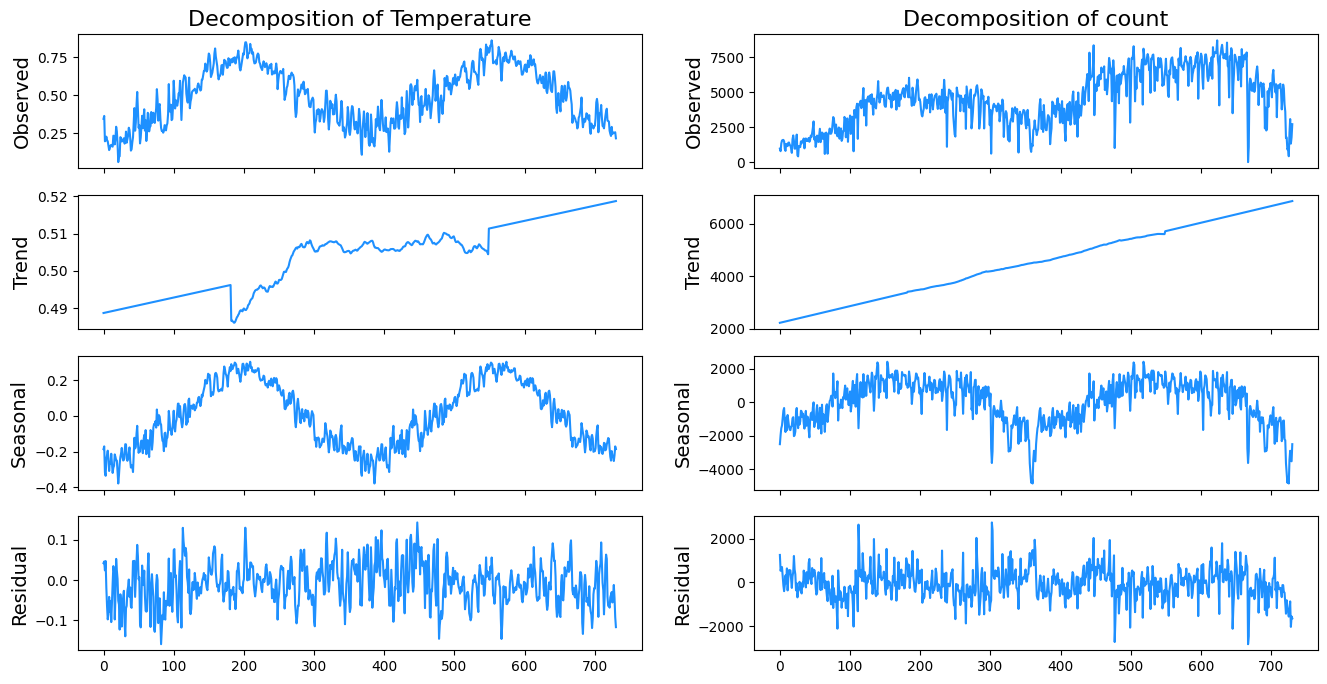

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))
res = seasonal_decompose(day_df.temperature, period=365, model='additive', extrapolate_trend='freq')

ax[0,0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0,0], legend=False, color='dodgerblue')
ax[0,0].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1,0], legend=False, color='dodgerblue')
ax[1,0].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2,0], legend=False, color='dodgerblue')
ax[2,0].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3,0], legend=False, color='dodgerblue')
ax[3,0].set_ylabel('Residual', fontsize=14)

ax[0,1].set_title('Decomposition of count', fontsize=16)
res = seasonal_decompose(day_df['count'], period=365, model='additive', extrapolate_trend='freq')

res.observed.plot(ax=ax[0, 1], legend=False, color='dodgerblue')
ax[0, 1].set_ylabel('Observed', fontsize=14)

res.trend.plot(ax=ax[1, 1], legend=False, color='dodgerblue')
ax[1, 1].set_ylabel('Trend', fontsize=14)

res.seasonal.plot(ax=ax[2, 1], legend=False, color='dodgerblue')
ax[2, 1].set_ylabel('Seasonal', fontsize=14)

res.resid.plot(ax=ax[3, 1], legend=False, color='dodgerblue')
ax[3, 1].set_ylabel('Residual', fontsize=14)

plt.show()

## <span style="color:powderblue">**Data Visualization**</span>

### <span style="color:lightcyan">**Data visualization over time**</span>

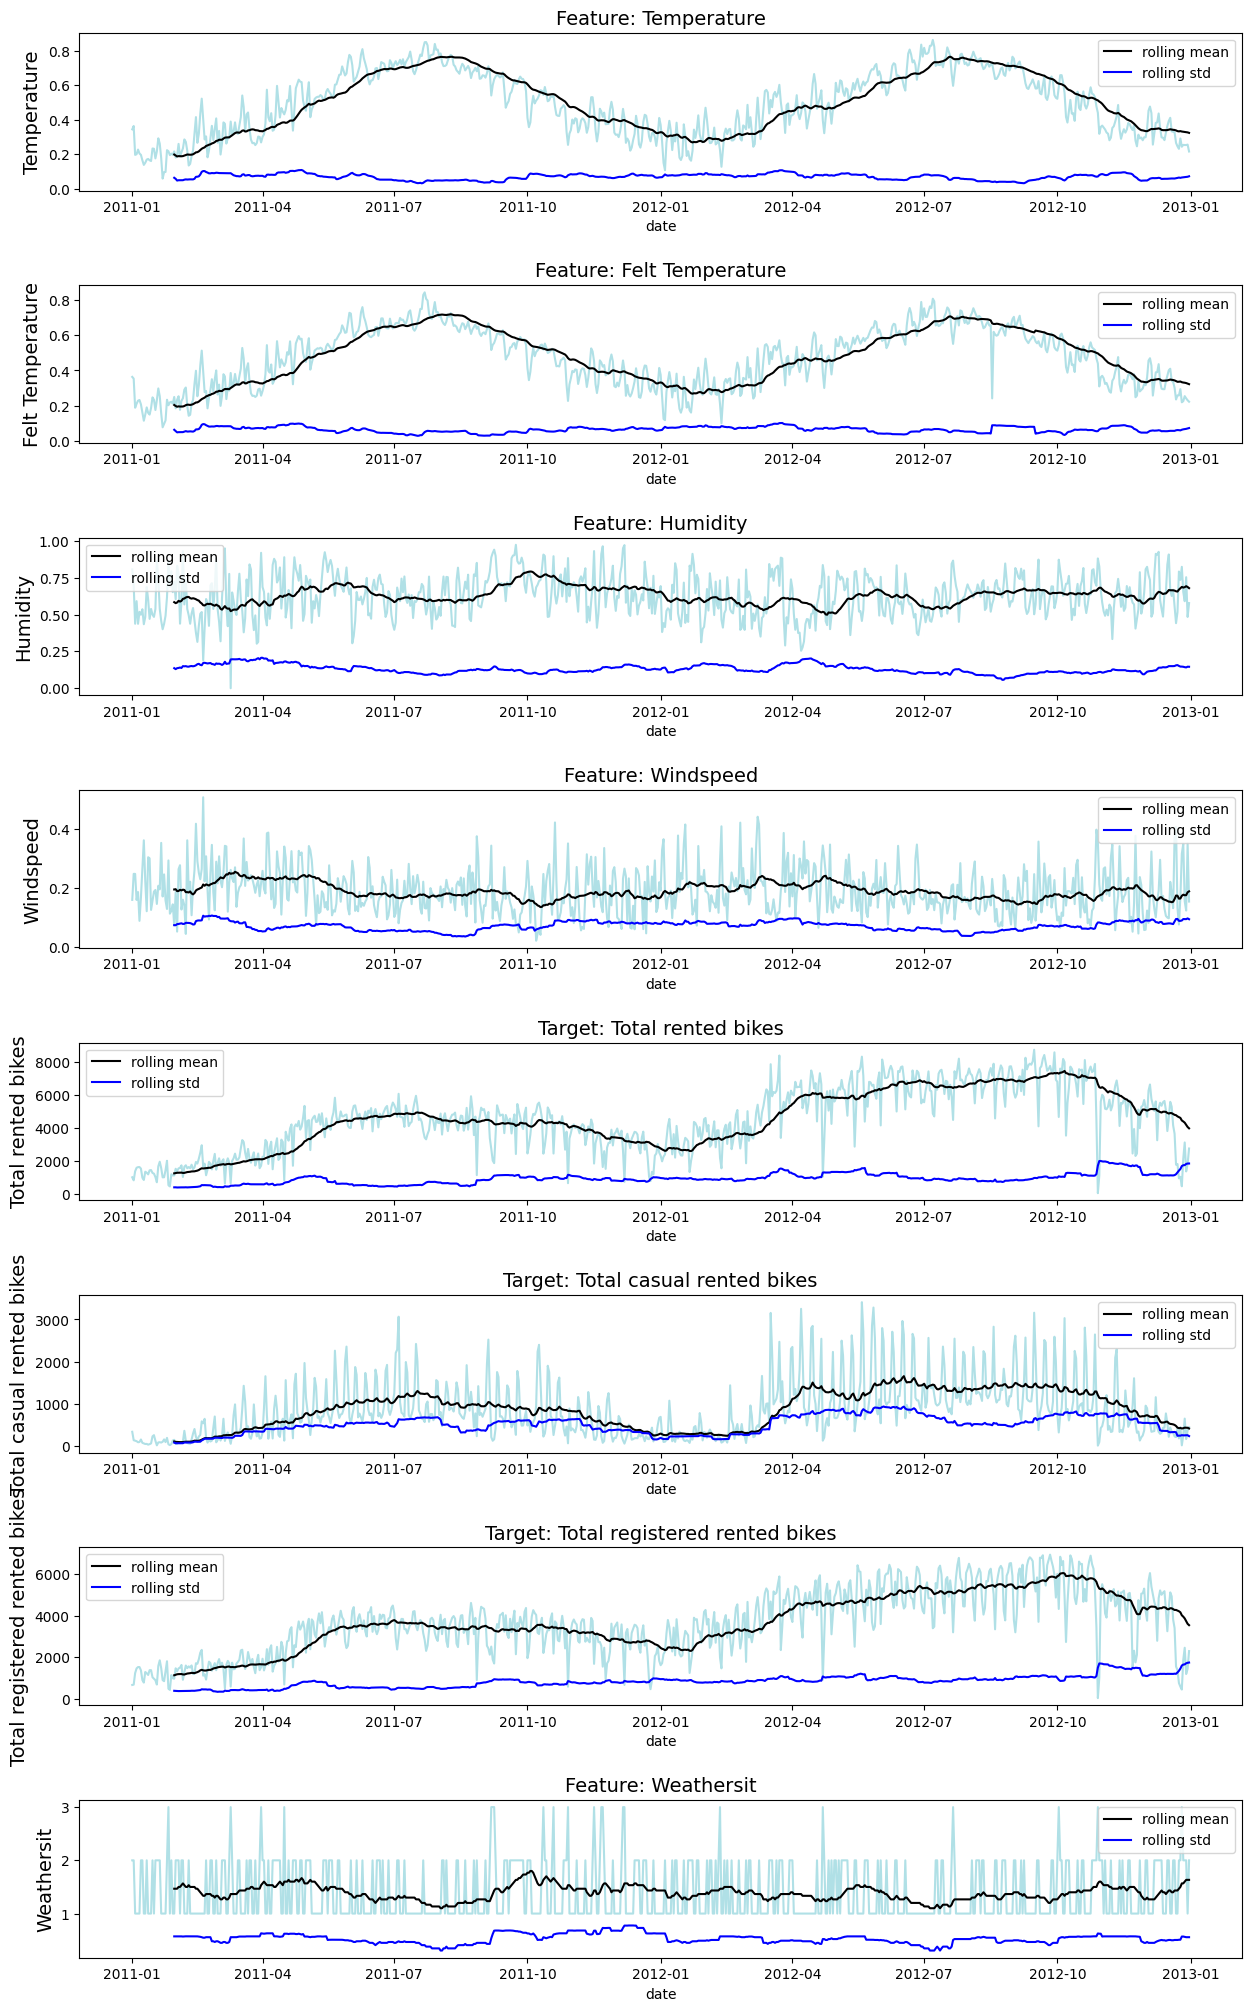

In [19]:
rolling_window = 30
f, ax = plt.subplots(nrows=8, ncols=1, figsize=(15, 25))

sns.lineplot(x=day_df.date, y=day_df.temperature, ax=ax[0], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).mean(), ax=ax[0], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.temperature.rolling(rolling_window).std(), ax=ax[0], color='blue', label='rolling std')
ax[0].set_title('Feature: Temperature', fontsize=14)
ax[0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.felt_temperature, ax=ax[1], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).mean(), ax=ax[1], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.felt_temperature.rolling(rolling_window).std(), ax=ax[1], color='blue', label='rolling std')
ax[1].set_title('Feature: Felt Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Felt Temperature', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.humidity, ax=ax[2], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).mean(), ax=ax[2], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.humidity.rolling(rolling_window).std(), ax=ax[2], color='blue', label='rolling std')
ax[2].set_title('Feature: Humidity', fontsize=14)
ax[2].set_ylabel(ylabel='Humidity', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.windspeed, ax=ax[3], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).mean(), ax=ax[3], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.windspeed.rolling(rolling_window).std(), ax=ax[3], color='blue', label='rolling std')
ax[3].set_title('Feature: Windspeed', fontsize=14)
ax[3].set_ylabel(ylabel='Windspeed', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df["count"], ax=ax[4], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).mean(), ax=ax[4], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df["count"].rolling(rolling_window).std(), ax=ax[4], color='blue', label='rolling std')
ax[4].set_title('Target: Total rented bikes', fontsize=14)
ax[4].set_ylabel(ylabel='Total rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.casual, ax=ax[5], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).mean(), ax=ax[5], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.casual.rolling(rolling_window).std(), ax=ax[5], color='blue', label='rolling std')
ax[5].set_title('Target: Total casual rented bikes', fontsize=14)
ax[5].set_ylabel(ylabel='Total casual rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.registered, ax=ax[6], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).mean(), ax=ax[6], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.registered.rolling(rolling_window).std(), ax=ax[6], color='blue', label='rolling std')
ax[6].set_title('Target: Total registered rented bikes', fontsize=14)
ax[6].set_ylabel(ylabel='Total registered rented bikes', fontsize=14)

sns.lineplot(x=day_df.date, y=day_df.weathersit, ax=ax[7], color="powderblue")
sns.lineplot(x=day_df.date, y=day_df.weathersit.rolling(rolling_window).mean(), ax=ax[7], color="black", label="rolling mean")
sns.lineplot(x=day_df.date, y=day_df.weathersit.rolling(rolling_window).std(), ax=ax[7], color='blue', label='rolling std')
ax[7].set_title('Feature: Weathersit', fontsize=14)
ax[7].set_ylabel(ylabel='Weathersit', fontsize=14)

plt.subplots_adjust(hspace=0.6)
plt.show()

### <span style="color:lightcyan">**Focus on Days**</span>

In [20]:
#day_df.count()
#day_df[["cnt","casual","registered"]].describe().round(1)

#### **Distribution of Bike Rentals**

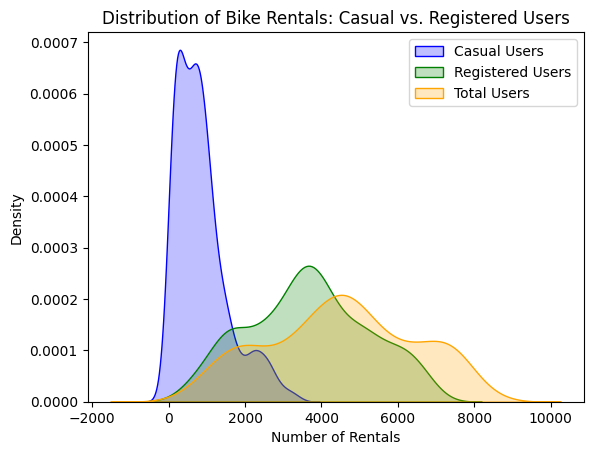

In [21]:
sns.kdeplot(day_df['casual'], fill=True, label='Casual Users', color='blue')
sns.kdeplot(day_df['registered'], fill=True, label='Registered Users', color='green')
sns.kdeplot(day_df['count'], fill=True, label="Total Users", color='orange')
plt.title("Distribution of Bike Rentals: Casual vs. Registered Users")
plt.xlabel("Number of Rentals")
plt.ylabel("Density")
plt.legend()

#### **Bike rentals over time by season**

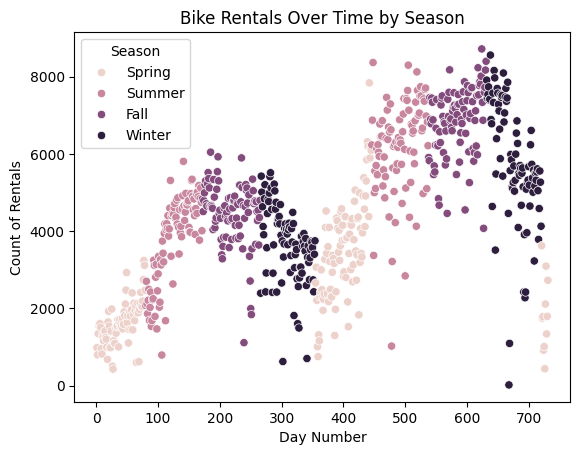

In [22]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["season"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Season")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Season", labels=["Spring", "Summer", "Fall", "Winter"])

#### **Bike rentals per weekdays**

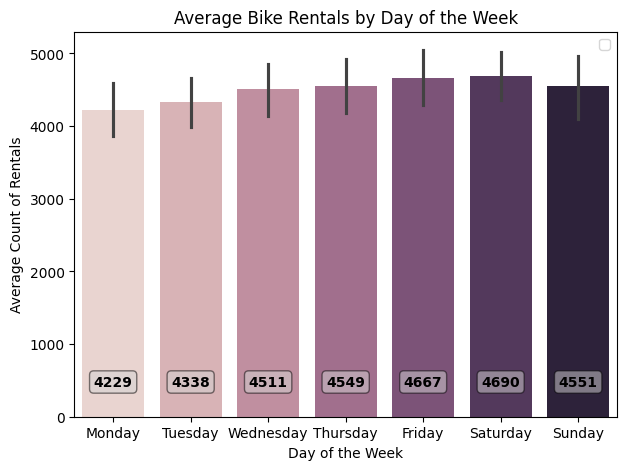

In [23]:
plt.figure(figsize=(7,5))
barplot = sns.barplot(data=day_df, x="weekday", y="count", hue=day_df["weekday"])
plt.title("Average Bike Rentals by Day of the Week")
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Average Count of Rentals")
plt.legend([], [])

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}', 
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center', 
                         fontsize=10, color='black', 
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rentals by temperature**

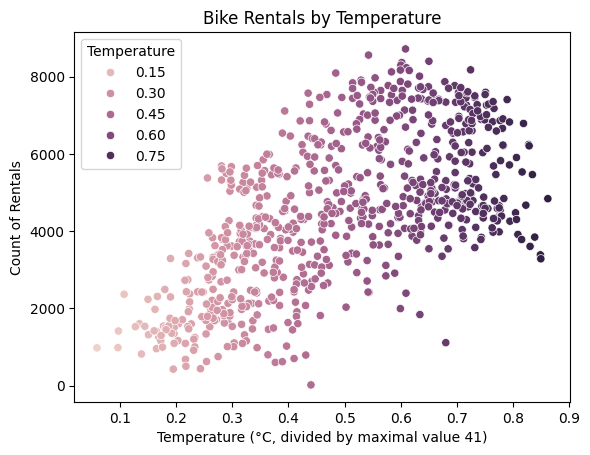

In [24]:
sns.scatterplot(day_df,x="temperature",y="count",hue=day_df["temperature"])
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature")

Text(15.875000000000009, 0.5, 'Count of Rentals')

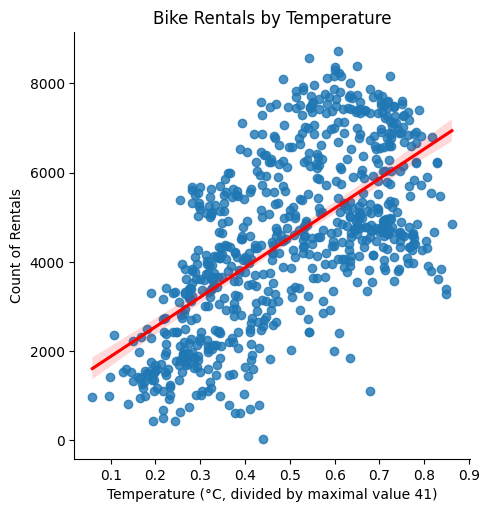

In [25]:
sns.lmplot(data=day_df, x="temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature")
plt.xlabel("Temperature (°C, divided by maximal value 41)")
plt.ylabel("Count of Rentals")

#### **Bike rentals by temperature felt**

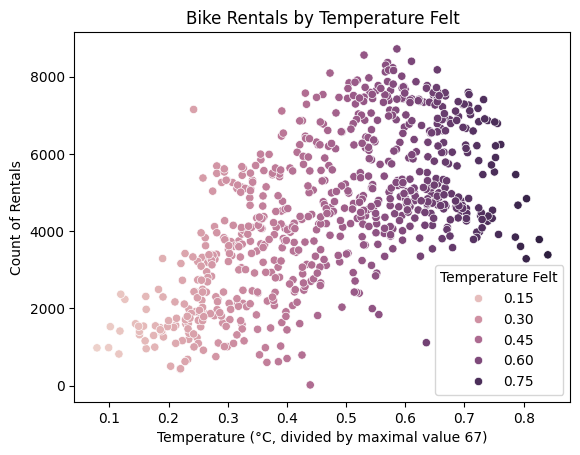

In [26]:
sns.scatterplot(day_df,x="felt_temperature",y="count",hue=day_df["felt_temperature"])
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")
plt.legend(title="Temperature Felt")

Text(15.875000000000009, 0.5, 'Count of Rentals')

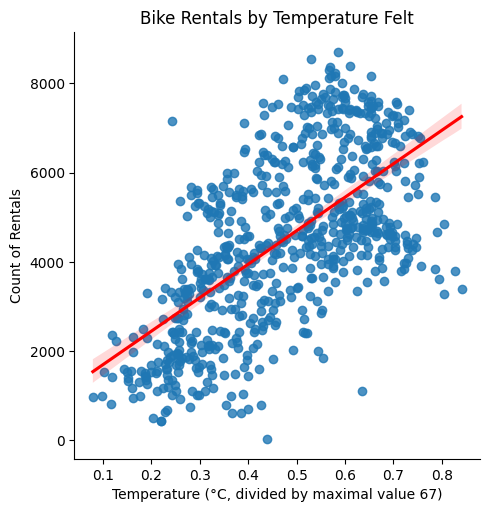

In [27]:
sns.lmplot(data=day_df, x="felt_temperature", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Temperature Felt")
plt.xlabel("Temperature (°C, divided by maximal value 67)")
plt.ylabel("Count of Rentals")

Clear correlation between temperature and bike rental amount (shocking)

#### **Bike rentals by humidity**

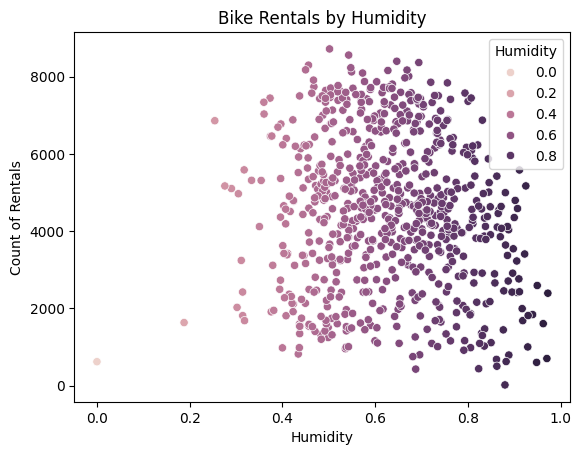

In [28]:
sns.scatterplot(day_df,x="humidity",y="count",hue=day_df["humidity"])
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")
plt.legend(title="Humidity")

Text(15.875000000000009, 0.5, 'Count of Rentals')

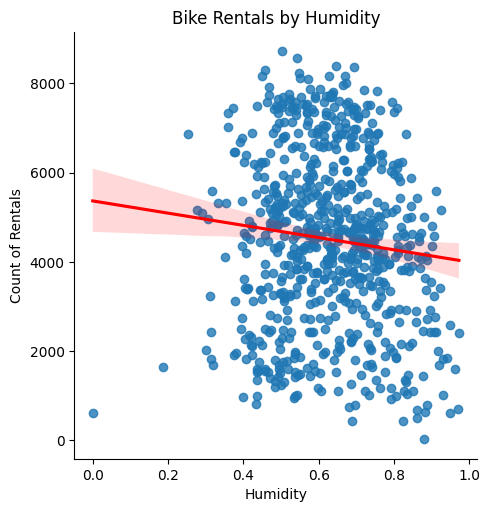

In [29]:
sns.lmplot(data=day_df, x="humidity", y="count",aspect=1, line_kws={'color': 'red'})
plt.title("Bike Rentals by Humidity")
plt.xlabel("Humidity")
plt.ylabel("Count of Rentals")

#### **Bike rentals by weather conditions**

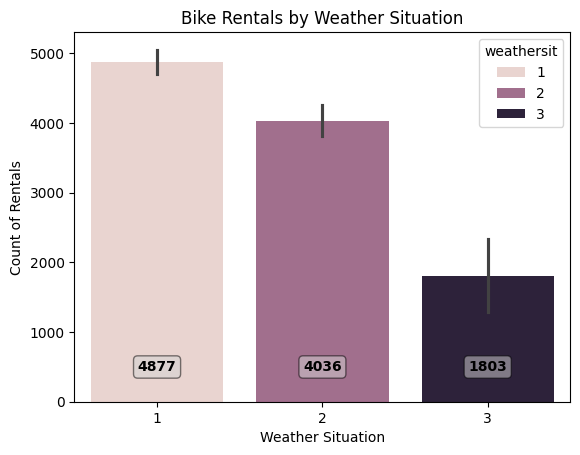

In [30]:
barplot = sns.barplot(data=day_df, x="weathersit", y="count", hue=day_df["weathersit"])
plt.title("Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Count of Rentals")

y_min = plt.gca().get_ylim()[0]

# Annotate each bar with a constant y-position, adding a rounded rectangle box with shading
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than zero
        barplot.annotate(f'{height:.0f}', 
                         (p.get_x() + p.get_width() / 2., y_min),
                         ha='center', va='center', 
                         fontsize=10, color='black', 
                         fontweight='bold',  # Make the font bold
                         xytext=(0, 25),  # No additional offset needed
                         textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray", alpha=0.5))

#### **Bike rental depending on wether the days are holidays or not**

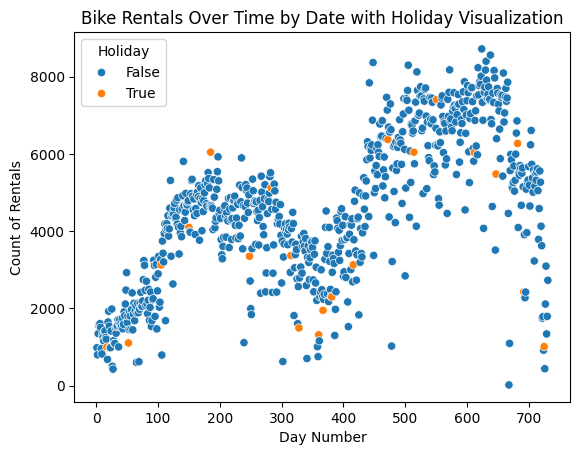

In [31]:
scatter = sns.scatterplot(day_df,x="instant",y="count",hue=day_df["holiday"])
handles, _ = scatter.get_legend_handles_labels()
plt.title("Bike Rentals Over Time by Date with Holiday Visualization")
plt.xlabel("Day Number")
plt.ylabel("Count of Rentals")
plt.legend(handles=handles, title="Holiday", labels=["False","True"])

No clear influence of holidays on the bike rental amount

### <span style="color:lightcyan">**Focus on Hours**</span>

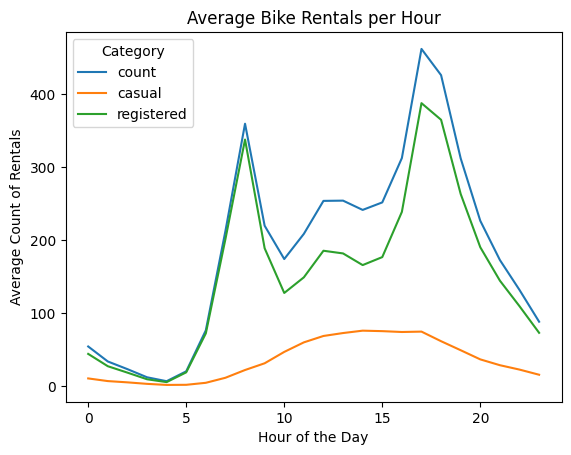

In [32]:
hourly_rentals = hour_df.groupby("hour")["count"].mean()
hourly_casual =  hour_df.groupby("hour")["casual"].mean()
hourly_registered =  hour_df.groupby("hour")["registered"].mean()
hourly_rentals.plot(kind='line')
hourly_casual.plot(kind='line')
hourly_registered.plot(kind='line')
plt.title("Average Bike Rentals per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Count of Rentals")
plt.legend(title="Category")
plt.grid(False)

### <span style="color:lightcyan">**Correlation Analysis**</span>

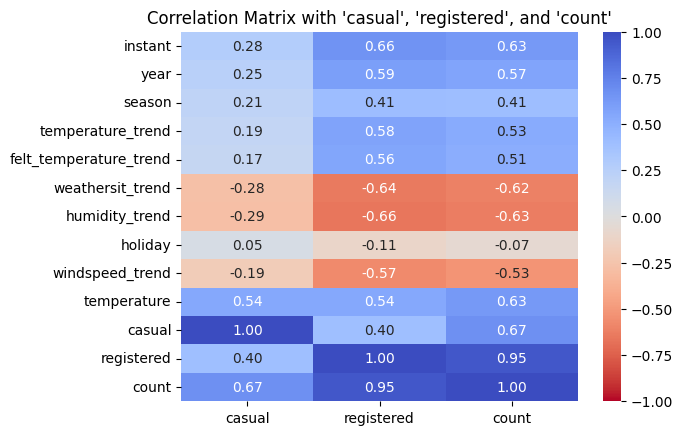

In [55]:
# recherche des features les plus importantes par une matrice d'autocorrélation
correlation_matrix = day_df.corr()
# Keep only the correlations with 'casual', 'registered', and 'cnt'
filtered_corr_matrix = correlation_matrix.loc[['instant','year','season','temperature_trend','felt_temperature_trend','weathersit_trend','humidity_trend','holiday','windspeed_trend','temperature','casual','registered','count'], ['casual', 'registered', 'count']].copy()

sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm_r", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix with 'casual', 'registered', and 'count'")
plt.show()

## <span style="color:powderblue">**Machine Learning**</span>

In [34]:
# fonctions de cout pour evaluer les modèles
def MAE(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    relative_mae = (mae / np.mean(y_test)) * 100
    return mae, relative_mae

def RMSE(y_test,y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2)) 
    relative_rmse = (rmse / np.mean(y_test)) * 100
    return rmse, relative_rmse

In [35]:
day_df.columns
day_df.set_index("instant")
day_df.sort_index(inplace=True)

In [46]:
# Sélection des caractéristiques pertinentes, y compris les nouvelles colonnes encodées
target = ['count']
not_feature = ['instant','date','casual_trend','casual_seasonal', 'registered_trend', 'registered_seasonal','count_trend', 'count_seasonal', 'count', 'registered', 'casual','year', 'season', 'quarter', 'month', 'week_of_year',
       'day', 'day_of_year', 'holiday', "quarter_cos", "quarter_sin", 'month_sin', 'month_cos', 'season_sin',
       'season_cos']
features = [feature for feature in day_df.columns if feature not in not_feature]

print(features)
# Séparation des données en jeu d'entraînement et jeu de test en utilisant timeseriessplit car les variables ne sont pas indépendantes du temps
# Le dataframe est déjà ordonnée en fonction du temps donc il est utilisable avec timeseriessplit
X = day_df[features]
y = day_df[target]

N_SPLITS = 5

tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# Fonction utilitaire pour calculer les KPI (MAE, RMSE, biais)
def compute_KPIs(Y_train, F_train, Y_test, F_test, name=''):
    if F_train.shape != Y_train.shape:
        F_train = F_train.reshape(-1, 1)
        F_test = F_test.reshape(-1, 1)

    # Calcul des indicateurs de performance
    df = pd.DataFrame(columns=['MAE', 'RMSE', 'ABS Bias'], index=['Train', 'Test'])
    df.index.name = name
    df.loc['Train', 'MAE'] = 100 * np.mean(abs(F_train - Y_train)) / np.mean(Y_train)
    df.loc['Train', 'RMSE'] = 100 * np.sqrt(np.mean((F_train - Y_train) ** 2)) / np.mean(Y_train)
    df.loc['Train', 'ABS Bias'] = 100 * abs(np.mean((F_train - Y_train)) / np.mean(Y_train))
    df.loc['Test', 'MAE'] = 100 * np.mean(abs(F_test - Y_test)) / np.mean(Y_test)
    df.loc['Test', 'RMSE'] = 100 * np.sqrt(np.mean((F_test - Y_test) ** 2)) / np.mean(Y_test)
    df.loc['Test', 'ABS Bias'] = 100 * abs(np.mean((F_test - Y_test)) / np.mean(Y_test))
    df = df.astype(float).round(2)  # Arrondir pour un affichage plus lisible
    print(df)
    return df

# Initialisation d'un dictionnaire pour stocker les KPI de chaque modèle
kpi_results = {}

['weekday', 'workingday', 'weathersit', 'temperature', 'felt_temperature', 'humidity', 'windspeed', 'day_sin', 'day_cos', 'day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos', 'temperature_trend', 'temperature_seasonal', 'felt_temperature_trend', 'felt_temperature_seasonal', 'humidity_trend', 'humidity_seasonal', 'windspeed_trend', 'windspeed_seasonal', 'weathersit_trend', 'weathersit_seasonal']


### Régression linéaire


=== Régression Linéaire ===
0
1
2
3
4
                     MAE   RMSE  ABS Bias
Linear Regression                        
Train              12.35  16.52      0.02
Test               20.35  26.08      4.86


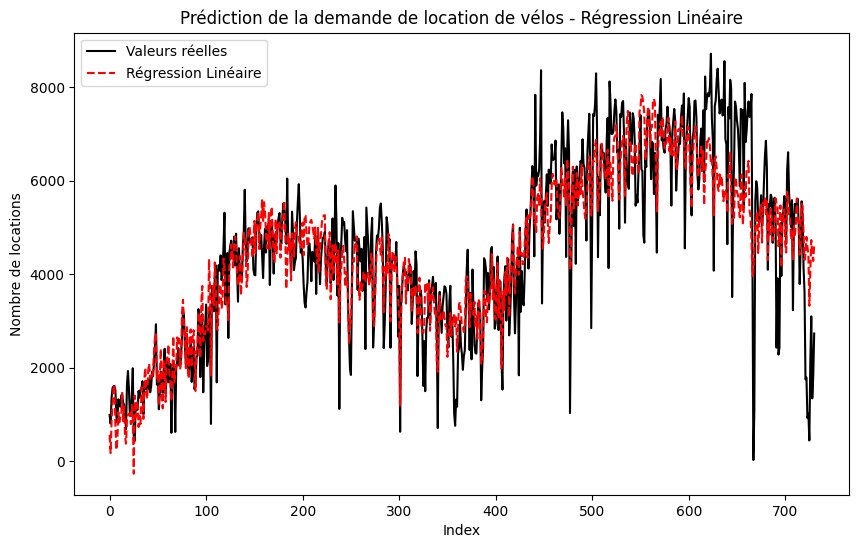

In [ ]:
print("\n=== Régression Linéaire ===")
linear_model = LinearRegression()
scores = []

for i, (train_index, test_index) in enumerate(tscv.split(X)): 
    print(i)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # ajout de features supplémentaires pour X_train
    X_train_new_features = pd.DataFrame({
    "Demand Mean": X_train.mean(axis=1),
    "Demand Median": X_train.median(axis=1),
    "Demand MA4": X_train.iloc[:, -4:].mean(axis=1),
    "Demand MA6": X_train.iloc[:, -6:].mean(axis=1),
    "Demand MA12": X_train.iloc[:, -12:].mean(axis=1),
    "Demand Max": X_train.max(axis=1),
    "Demand Min": X_train.min(axis=1),
    "Demand Variance": X_train.var(axis=1),
    "Demand Range": X_train.max(axis=1) - X_train.min(axis=1),
    "Demand Growth Rate": (X_train.iloc[:, -1] - X_train.iloc[:, 0]) / X_train.shape[1],
    "Demand Cumulative Sum": X_train.cumsum(axis=1).iloc[:, -1],
    })

    # ajout des memes features supplémentaires pour X_test
    X_test_new_features = pd.DataFrame({
        "Demand Mean": X_test.mean(axis=1),
        "Demand Median": X_test.median(axis=1),
        "Demand MA4": X_test.iloc[:, -4:].mean(axis=1),
        "Demand MA6": X_test.iloc[:, -6:].mean(axis=1),
        "Demand MA12": X_test.iloc[:, -12:].mean(axis=1),
        "Demand Max": X_test.max(axis=1),
        "Demand Min": X_test.min(axis=1),
        "Demand Variance": X_test.var(axis=1),
        "Demand Range": X_test.max(axis=1) - X_test.min(axis=1),
        "Demand Growth Rate": (X_test.iloc[:, -1] - X_test.iloc[:, 0]) / X_test.shape[1],
        "Demand Cumulative Sum": X_test.cumsum(axis=1).iloc[:, -1],
    })

    # Concaténation des nouvelles et des anciennes features pour avoir un dataset augmenté des nouvelles features
    X_train_new_features = pd.concat([X_train, 
                                    X_train_new_features], axis=1)
    X_test_new_features = pd.concat([X_test, 
                                    X_test_new_features], axis=1)

    # fitting du modele et calcul du score pour le split en cours
    linear_model.fit(X_train_new_features, y_train)
    score = linear_model.score(X_test_new_features, y_test)
    scores.append(score)

# training du modèle avec les meilleurs paramètres du time series split
y_pred_train_lr = linear_model.predict(X_train_new_features)
y_pred_test_lr = linear_model.predict(X_test_new_features)
kpi_results['Linear Regression'] = compute_KPIs(y_train, y_pred_train_lr, y_test, y_pred_test_lr, name='Linear Regression')

y_pred = np.append(y_pred_train_lr,y_pred_test_lr)


plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Valeurs réelles', color='black')
plt.plot(y_pred, label='Régression Linéaire', linestyle='--', color='red')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Régression Linéaire')
plt.legend()
plt.show()

In [48]:
scores

[-141.9719708823383,
 -0.33736615847212503,
 -0.1959432705213,
 -0.054511811993004144,
 0.4325039267247508]

### Decision Tree


=== Arbre de Décision ===
0
1
2
3
4
                 MAE   RMSE  ABS Bias
Decision Tree                        
Train           2.64   4.54      0.00
Test           18.88  26.68      4.64


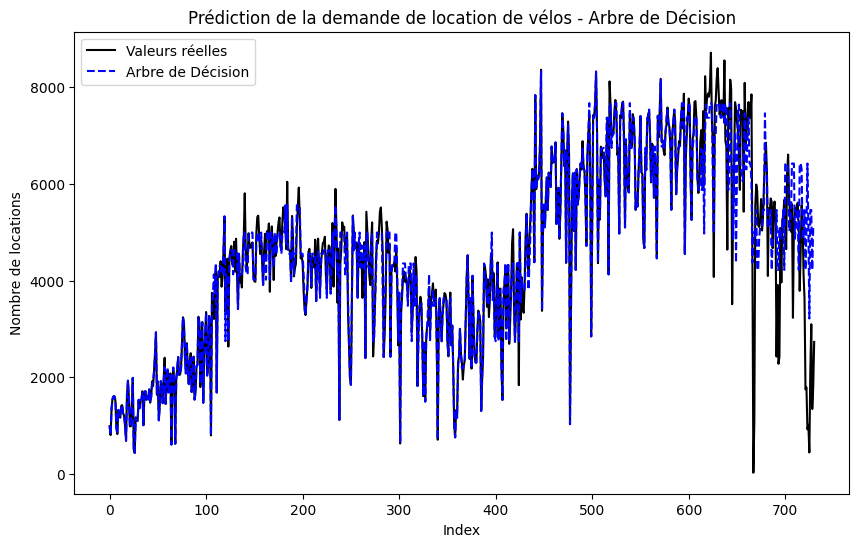

In [ ]:
print("\n=== Arbre de Décision ===")
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)

scores = []
for i, (train_index, test_index) in enumerate(tscv.split(X)): 
    print(i)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # ajout de features supplémentaires pour X_train
    X_train_new_features = pd.DataFrame({
    "Demand Mean": X_train.mean(axis=1),
    "Demand Median": X_train.median(axis=1),
    "Demand MA4": X_train.iloc[:, -4:].mean(axis=1),
    "Demand MA6": X_train.iloc[:, -6:].mean(axis=1),
    "Demand MA12": X_train.iloc[:, -12:].mean(axis=1),
    "Demand Max": X_train.max(axis=1),
    "Demand Min": X_train.min(axis=1),
    "Demand Variance": X_train.var(axis=1),
    "Demand Range": X_train.max(axis=1) - X_train.min(axis=1),
    "Demand Growth Rate": (X_train.iloc[:, -1] - X_train.iloc[:, 0]) / X_train.shape[1],
    "Demand Cumulative Sum": X_train.cumsum(axis=1).iloc[:, -1],
    })

    X_test_new_features = pd.DataFrame({
        "Demand Mean": X_test.mean(axis=1),
        "Demand Median": X_test.median(axis=1),
        "Demand MA4": X_test.iloc[:, -4:].mean(axis=1),
        "Demand MA6": X_test.iloc[:, -6:].mean(axis=1),
        "Demand MA12": X_test.iloc[:, -12:].mean(axis=1),
        "Demand Max": X_test.max(axis=1),
        "Demand Min": X_test.min(axis=1),
        "Demand Variance": X_test.var(axis=1),
        "Demand Range": X_test.max(axis=1) - X_test.min(axis=1),
        "Demand Growth Rate": (X_test.iloc[:, -1] - X_test.iloc[:, 0]) / X_test.shape[1],
        "Demand Cumulative Sum": X_test.cumsum(axis=1).iloc[:, -1],
    })

    # Concaténation des nouvelles et des anciennes features pour avoir un dataset augmenté des nouvelles features
    X_train_new_features = pd.concat([X_train, 
                                    X_train_new_features], axis=1)
    X_test_new_features = pd.concat([X_test, 
                                    X_test_new_features], axis=1)

    # fitting du modele sur chaque split
    tree_model.fit(X_train_new_features, y_train)
    score = tree_model.score(X_test_new_features, y_test)
    scores.append(score)

# training du modèle avec les meilleurs paramètres du time series split
y_pred_train_tree = tree_model.predict(X_train_new_features)
y_pred_test_tree = tree_model.predict(X_test_new_features)
kpi_results['Decision Tree'] = compute_KPIs(y_train, y_pred_train_tree, y_test, y_pred_test_tree, name='Decision Tree')

y_pred = np.append(y_pred_train_tree,y_pred_test_tree)

plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Valeurs réelles', color='black')
plt.plot(y_pred, label='Arbre de Décision', linestyle='--', color='blue')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Arbre de Décision')
plt.legend()
plt.show()

<Axes: >

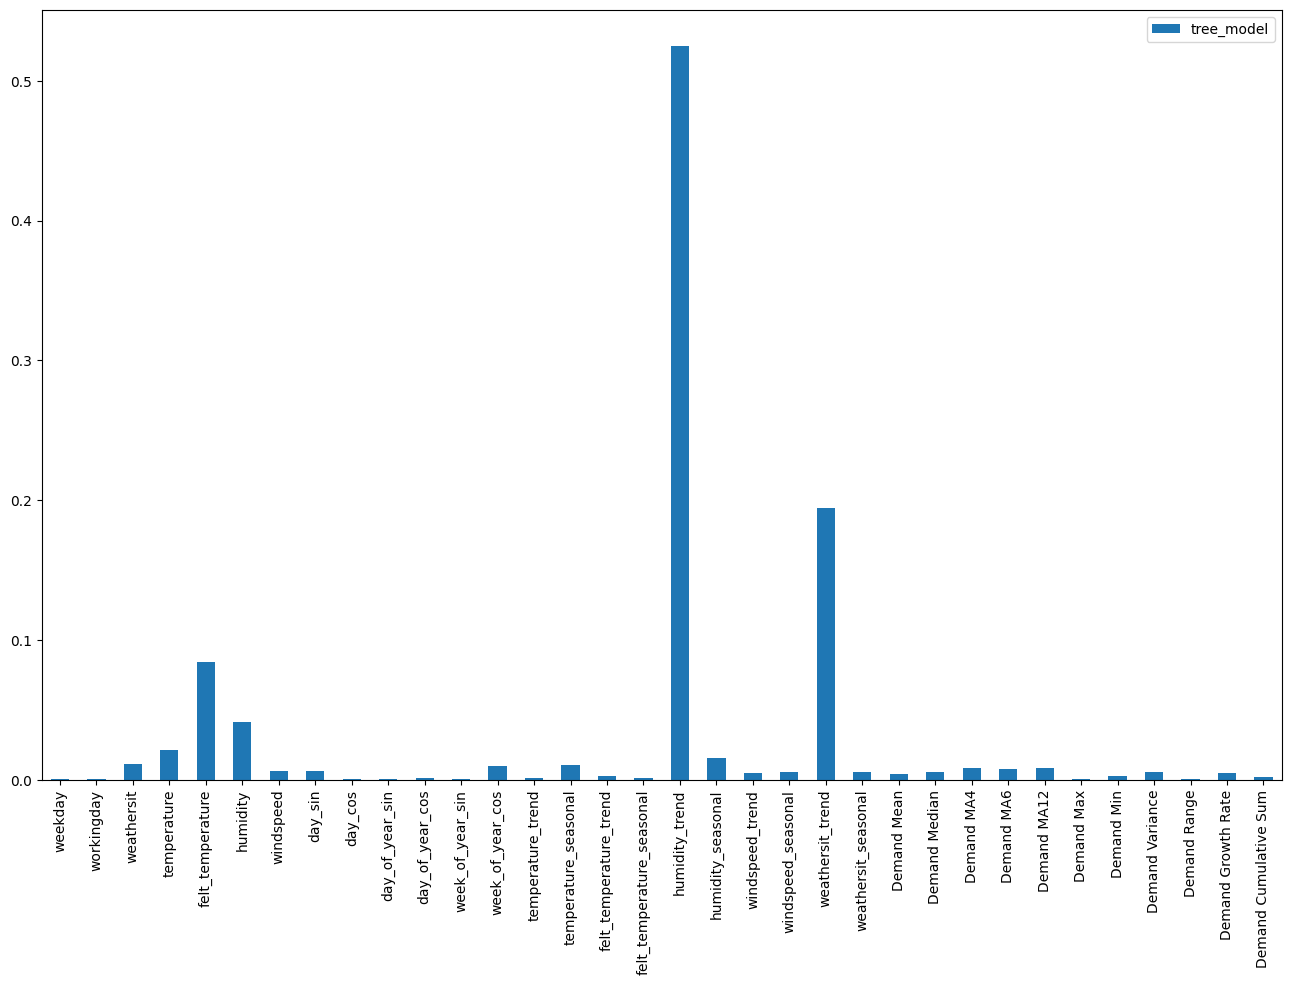

In [54]:
# Visualisation de l'importance des features dans notre modèle de random forest
features = pd.DataFrame(data=tree_model.feature_importances_.reshape(-1,1), index=X_train_new_features.columns, columns=["tree_model"])
features["tree_model"] * 100 
features.plot(kind='bar',figsize=(16,10))

### Foret Aléatoire


=== Forêt Aléatoire ===
0


/Users/clementribe/Documents/Code/ProjetML/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


1


/Users/clementribe/Documents/Code/ProjetML/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


2


/Users/clementribe/Documents/Code/ProjetML/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


3


/Users/clementribe/Documents/Code/ProjetML/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


4


/Users/clementribe/Documents/Code/ProjetML/myenv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                 MAE   RMSE  ABS Bias
Random Forest                        
Train           3.65   5.28      0.02
Test           16.94  23.99      0.27


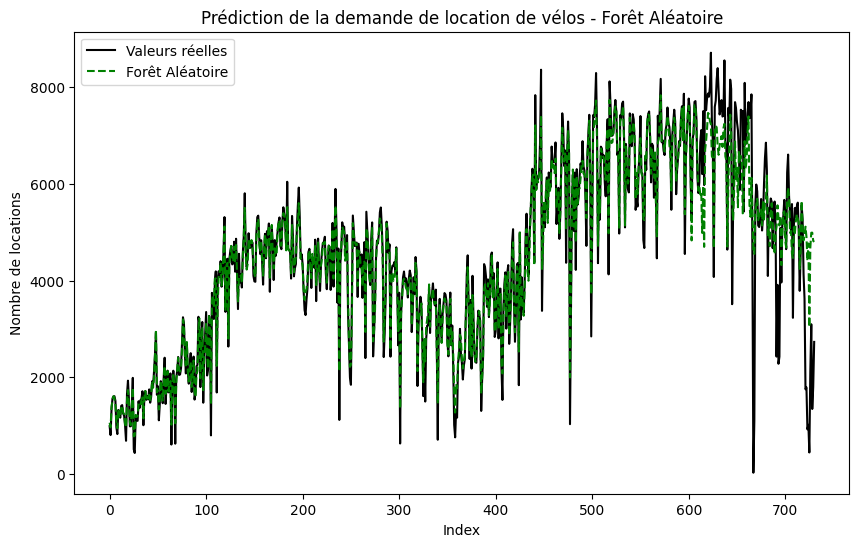

In [ ]:
print("\n=== Forêt Aléatoire ===")
forest_model = RandomForestRegressor(n_estimators=500, random_state=42,n_jobs=-1,bootstrap=True)

scores = []
for i, (train_index, test_index) in enumerate(tscv.split(X)): 
    print(i)
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # ajout de features supplémentaires pour X_train
    X_train_new_features = pd.DataFrame({
    "Demand Mean": X_train.mean(axis=1),
    "Demand Median": X_train.median(axis=1),
    "Demand MA4": X_train.iloc[:, -4:].mean(axis=1),
    "Demand MA6": X_train.iloc[:, -6:].mean(axis=1),
    "Demand MA12": X_train.iloc[:, -12:].mean(axis=1),
    "Demand Max": X_train.max(axis=1),
    "Demand Min": X_train.min(axis=1),
    "Demand Variance": X_train.var(axis=1),
    "Demand Range": X_train.max(axis=1) - X_train.min(axis=1),
    "Demand Growth Rate": (X_train.iloc[:, -1] - X_train.iloc[:, 0]) / X_train.shape[1],
    "Demand Cumulative Sum": X_train.cumsum(axis=1).iloc[:, -1],
    })

    # ajout des memes features supplémentaires pour X_test
    X_test_new_features = pd.DataFrame({
        "Demand Mean": X_test.mean(axis=1),
        "Demand Median": X_test.median(axis=1),
        "Demand MA4": X_test.iloc[:, -4:].mean(axis=1),
        "Demand MA6": X_test.iloc[:, -6:].mean(axis=1),
        "Demand MA12": X_test.iloc[:, -12:].mean(axis=1),
        "Demand Max": X_test.max(axis=1),
        "Demand Min": X_test.min(axis=1),
        "Demand Variance": X_test.var(axis=1),
        "Demand Range": X_test.max(axis=1) - X_test.min(axis=1),
        "Demand Growth Rate": (X_test.iloc[:, -1] - X_test.iloc[:, 0]) / X_test.shape[1],
        "Demand Cumulative Sum": X_test.cumsum(axis=1).iloc[:, -1],
    })

    # Concaténation des nouvelles et des anciennes features pour avoir un dataset augmenté des nouvelles features
    X_train_new_features = pd.concat([X_train, 
                                    X_train_new_features], axis=1)
    X_test_new_features = pd.concat([X_test, 
                                    X_test_new_features], axis=1)

    # fitting du model sur chaque split
    forest_model.fit(X_train_new_features, y_train)
    score = forest_model.score(X_test_new_features, y_test)
    scores.append(score)

# training du modèle avec les meilleurs paramètres du time series split
y_pred_train_forest = forest_model.predict(X_train_new_features)
y_pred_test_forest = forest_model.predict(X_test_new_features)
kpi_results['Random Forest'] = compute_KPIs(y_train, y_pred_train_forest, y_test, y_pred_test_forest, name='Random Forest')

y_pred = np.append(y_pred_train_forest,y_pred_test_forest)

plt.figure(figsize=(10, 6))
plt.plot(y.values, label='Valeurs réelles', color='black')
plt.plot(y_pred, label='Forêt Aléatoire', linestyle='--', color='green')
plt.xlabel('Index')
plt.ylabel('Nombre de locations')
plt.title('Prédiction de la demande de location de vélos - Forêt Aléatoire')
plt.legend()
plt.show()



<Axes: >

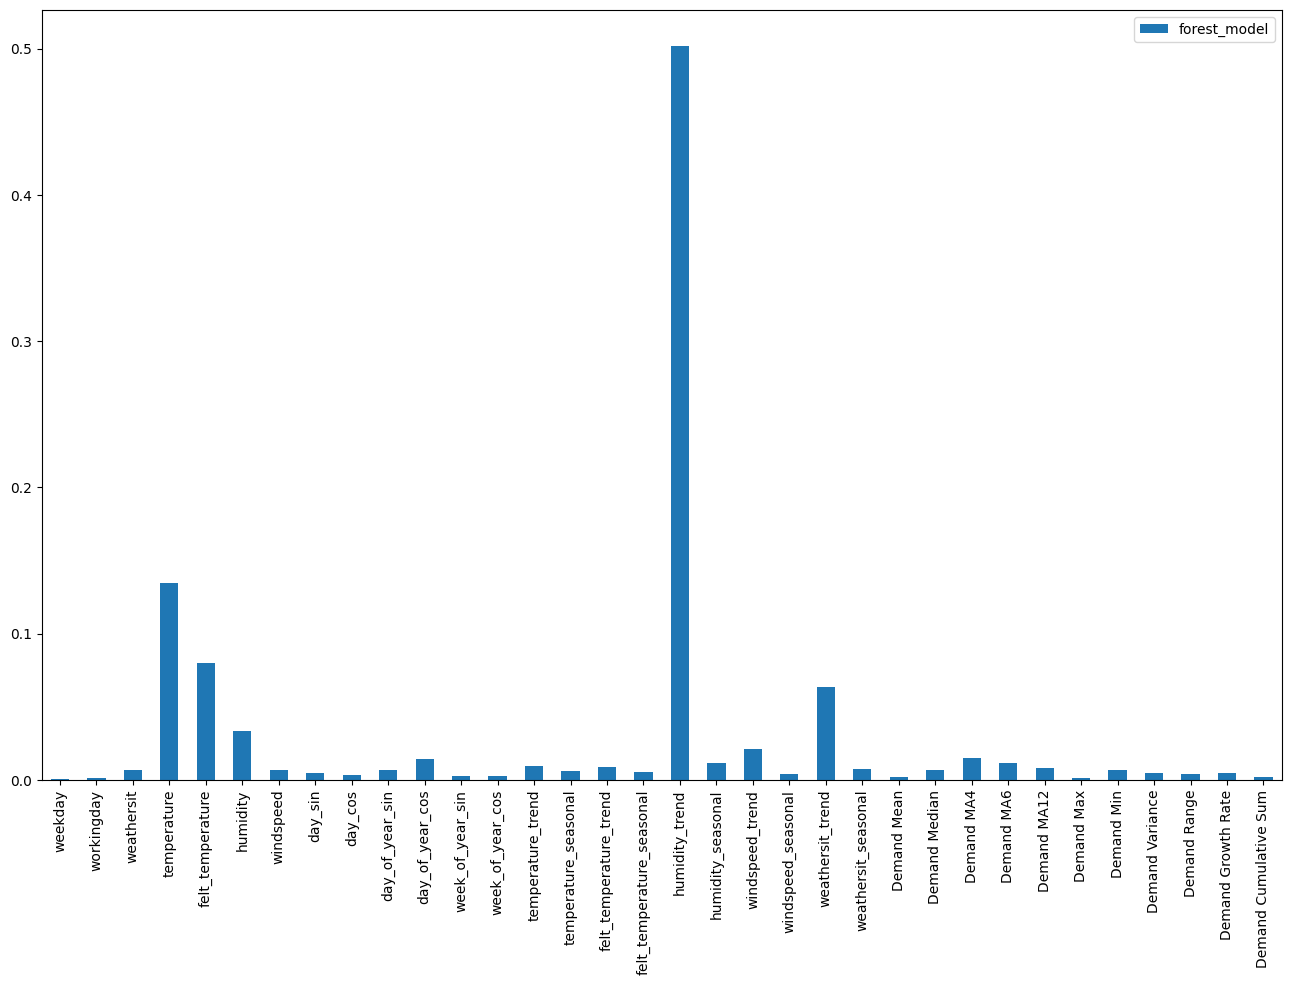

In [ ]:
# Visualisation de l'importance des features dans notre modèle de random forest
features = pd.DataFrame(data=forest_model.feature_importances_.reshape(-1,1), index=X_train_new_features.columns, columns=["forest_model"])
features["forest_model"] * 100 
features.plot(kind='bar',figsize=(16,10))

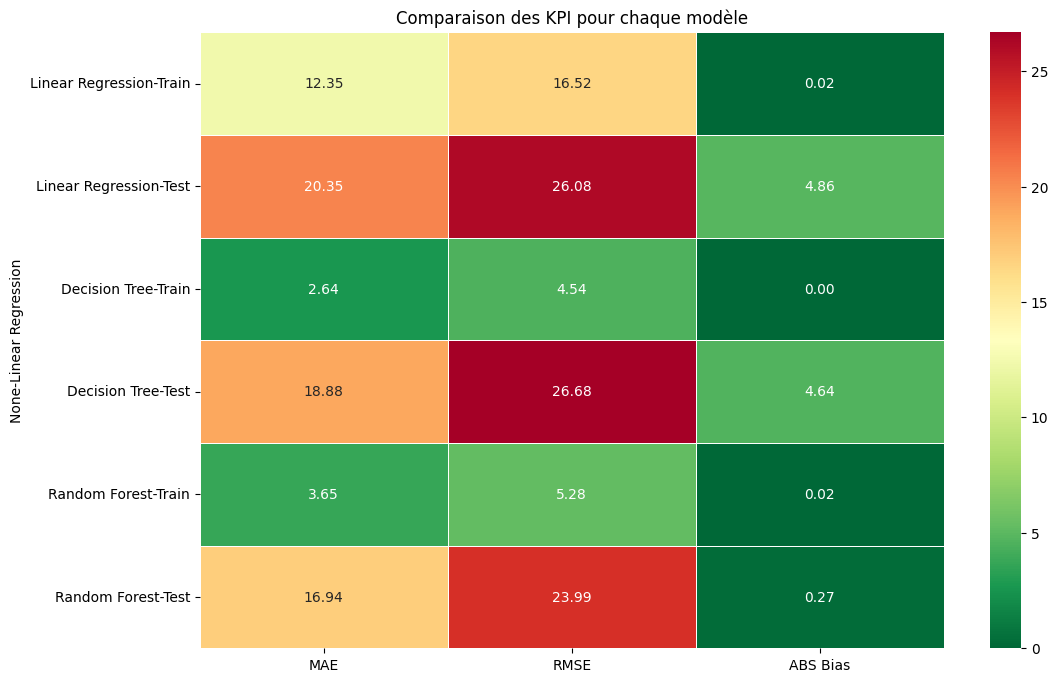

In [52]:
# Combiner tous les KPI dans un seul DataFrame pour comparaison
kpi_combined = pd.concat(kpi_results, axis=0)

# Afficher les KPI avec un code couleur (le plus grand est le plus rouge)
plt.figure(figsize=(12, 8))
sns.heatmap(kpi_combined, annot=True, cmap='RdYlGn_r', linewidths=0.5, fmt=".2f")
plt.title('Comparaison des KPI pour chaque modèle')
plt.show()